In [1]:
import openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_excel('C:/Users/nagpa/Desktop/traffic ml/trafficAnalysis/filtered_final_df3.xlsx')

In [3]:
df.head()

,VehicleSpeedAverage,VehicleSpeedVariance,LongitudinalAcceleration,EngineLoad,EngineCoolantTemperature,ManifoldAbsolutePressure,EngineRPM,MassAirFlow,IntakeAirTemperature,VerticalAcceleration,FuelConsumptionAverage,mahala,traffic
0,6.060,115.840061,1.0548,38.039215,31,101,798.0,6.22,15,-0.5982,27.919697,17.937478,1
1,6.345,117.200816,0.9012,38.039215,31,101,797.5,6.27,15,-0.5244,26.458355,13.499702,1
2,6.585,117.559595,0.9331,90.588234,32,101,797.5,6.27,15,-0.5068,26.458355,17.521610,1
3,6.825,117.801222,0.9878,90.588234,32,101,726.0,8.63,15,-0.4882,26.004126,18.987033,1
4,7.065,117.925697,1.1316,92.941177,32,101,784.0,8.88,15,-0.6712,25.295498,17.767989,1


In [4]:
df['traffic'].value_counts()

1    7548
3    2447
2    2414
Name: traffic, dtype: int64

In [5]:
df = df.drop(columns='mahala')

In [6]:
# putting feature variables in X
X = df.drop('traffic',axis=1)
#putting target variable in Y
Y = df['traffic']

In [8]:
from imblearn.over_sampling import SMOTE

In [9]:
smote = SMOTE(random_state=42)

In [10]:
X_smote, Y_smote = smote.fit_resample(X, Y)

In [11]:
# splitting data into train and test
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X_smote,Y_smote, train_size = 0.65,random_state=42)

In [12]:
X_train.shape, X_test.shape

((14718, 11), (7926, 11))

## 1. Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

classifier_rf = RandomForestClassifier(random_state = 42, n_jobs = 1, max_depth = 5,
                                       n_estimators=100,oob_score=True,max_features=3)

In [14]:
%%time
classifier_rf.fit(X_train,Y_train)

Wall time: 1.21 s


RandomForestClassifier(max_depth=5, max_features=3, n_jobs=1, oob_score=True,
                       random_state=42)

In [15]:
classifier_rf.oob_score_

0.8611903791275989

In [16]:
# hyper parameter tuning using grid search

rf = RandomForestClassifier(random_state=42,n_jobs=1)

params = {
    'max_depth' : [2,3,5,10,20],
    'min_samples_leaf' : [5,10,20,50,100,200],
    'n_estimators' : [10,25,30,50,100,200]
}

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=1, verbose=1, scoring = "accuracy")

In [17]:
%%time
grid_search.fit(X_train,Y_train)

Fitting 4 folds for each of 180 candidates, totalling 720 fits
Wall time: 6min 59s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=1, random_state=42),
             n_jobs=1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [18]:
grid_search.best_score_

0.9783255913409835

In [88]:
results_rf = pd.DataFrame(grid_search.cv_results_)
scores_rf = results_rf[['mean_test_score', 'param_n_estimators',  'param_min_samples_leaf']]
scores_rf = scores_rf.sort_values(by = 'mean_test_score',ascending = False)

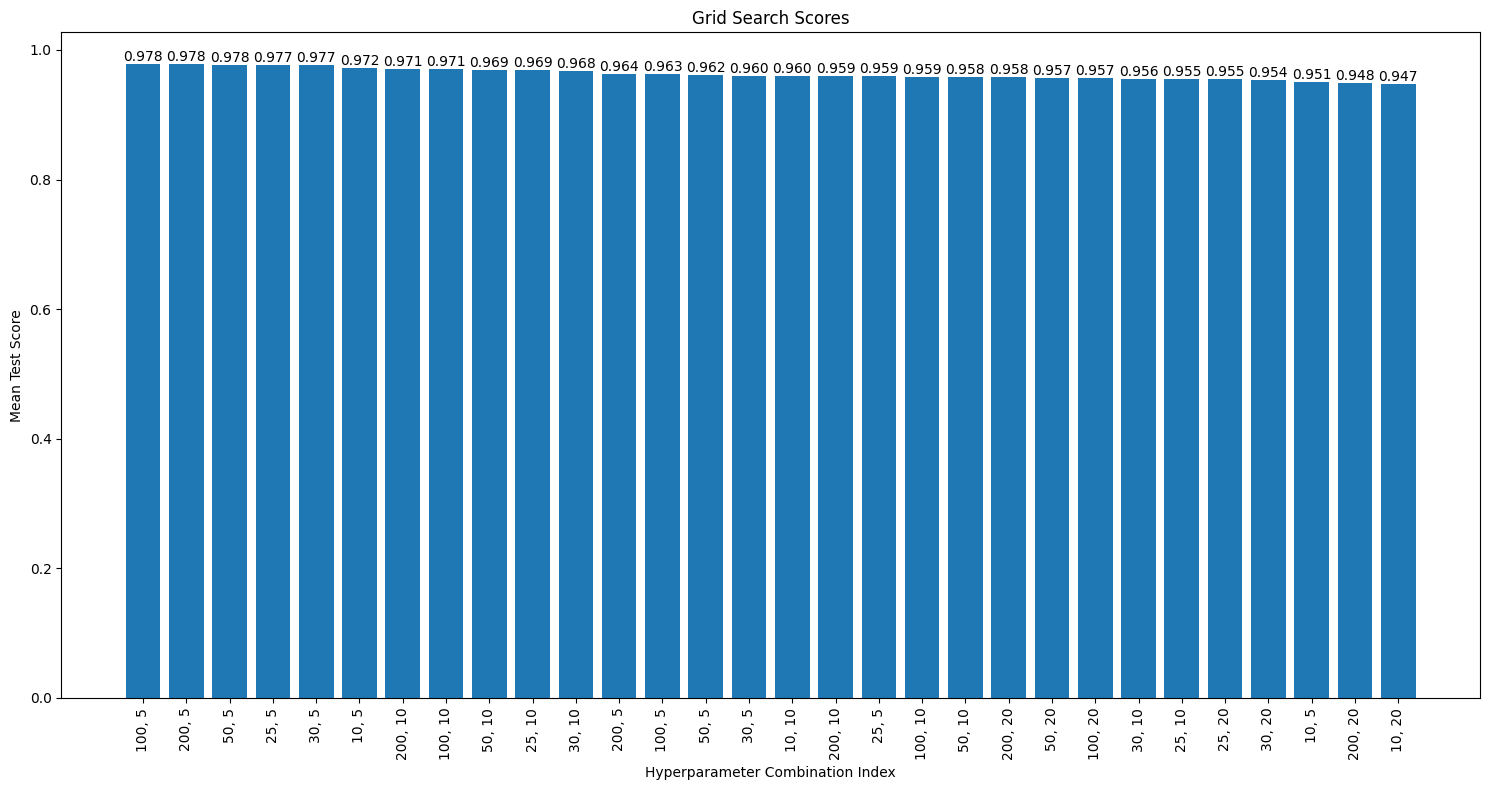

In [89]:
scores_rf = scores_rf.nlargest(30,'mean_test_score')

plt.figure(figsize = (15,8))
plt.bar(range(len(scores_rf)),scores_rf['mean_test_score'],align='center')

for i, score in enumerate(scores_rf['mean_test_score']):
    plt.text(i,score,f'{score:.3f}', ha='center', va='bottom')


plt.title('Grid Search Scores')
plt.xlabel('Hyperparameter Combination Index')
plt.ylabel('Mean Test Score')
plt.xticks(range(len(scores_rf)), [f"{row.param_n_estimators}, {row.param_min_samples_leaf}"
                                 for idx, row in scores_rf.iterrows()], rotation=90)

# Adjust layout to fit labels
plt.tight_layout()

# Show the plot
plt.show()

In [21]:
best_hyperparams = grid_search.best_params_
print("Best Hyperparameters:", best_hyperparams)

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 100}


In [22]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_jobs=1,
                       random_state=42)

In [23]:
Y_pred = rf_best.predict(X_test)

In [24]:
from sklearn import metrics 

In [25]:
print("ACCURACY OF THE MODEL:", metrics.accuracy_score(Y_test, Y_pred))

ACCURACY OF THE MODEL: 0.9799394398183194


In [26]:
X_test

,VehicleSpeedAverage,VehicleSpeedVariance,LongitudinalAcceleration,EngineLoad,EngineCoolantTemperature,ManifoldAbsolutePressure,EngineRPM,MassAirFlow,IntakeAirTemperature,VerticalAcceleration,FuelConsumptionAverage
20298,18.199213,169.829320,-0.107461,41.176472,39,102,791.807958,5.876046,13,-0.111366,19.729769
5170,38.279999,42.132811,0.852500,0.000000,79,109,1662.500000,20.879999,35,-0.547900,9.439765
15551,49.762536,512.171418,0.839549,30.098084,79,103,752.750112,4.662301,28,-0.642911,14.047907
15642,36.722035,87.521040,-0.763342,67.247684,69,108,1447.455886,16.144007,19,-0.234356,13.247760
12371,36.104999,247.725211,-0.241000,30.588236,77,102,759.500000,4.740000,19,-0.369200,12.438296
...,...,...,...,...,...,...,...,...,...,...,...
4089,2.985000,76.290781,0.515100,30.196079,78,103,755.000000,4.690000,36,-0.988000,9.847162
22399,22.450789,26.798692,-0.626712,64.103229,59,119,1893.690717,22.096331,24,0.571358,17.355587
9690,22.739999,141.705146,0.751000,72.549019,62,105,1221.000000,14.300000,18,-0.571700,13.842172
18075,5.492559,0.179936,-0.210255,34.996831,52,102,782.120960,9.690000,17,-0.053409,18.388115


In [27]:
Y_test

20298    3
5170     1
15551    2
15642    2
12371    2
        ..
4089     1
22399    3
9690     2
18075    3
16107    2
Name: traffic, Length: 7926, dtype: int64

In [28]:
rf_best.predict([[12.66,36,-0.2,38,44,102,790,5.5,16,-.1,20]])

c:\Users\nagpa\miniconda3\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([3], dtype=int64)

In [30]:
rf_best.predict([[30,5,0,20,80,100,1500,10,25,0,5]])

c:\Users\nagpa\miniconda3\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([1], dtype=int64)

In [34]:
rf_best.predict([[10,20,-1,70,100,120,2500,25,40,0.5,10]])

c:\Users\nagpa\miniconda3\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([1], dtype=int64)

In [35]:
Y_smote

0        1
1        1
2        1
3        1
4        1
        ..
22639    3
22640    3
22641    3
22642    3
22643    3
Name: traffic, Length: 22644, dtype: int64

In [36]:
pd.Series(Y_smote).value_counts()

1    7548
2    7548
3    7548
Name: traffic, dtype: int64

In [39]:
rf_best.predict([[3.3,24,-0.2,33,49,102,780,5,18,-0.07,22]])

c:\Users\nagpa\miniconda3\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([3], dtype=int64)

In [40]:
rf_best.predict([[30,45,0.03,55,70,117,1900,20,31,-0.2,13]])

c:\Users\nagpa\miniconda3\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([2], dtype=int64)

In [41]:
merged_test_data = pd.concat([X_test, Y_test], axis=1)

In [45]:
normal_congestion = merged_test_data[merged_test_data['traffic']==2]
low_congestion = merged_test_data[merged_test_data['traffic']==1]
high_congestion = merged_test_data[merged_test_data['traffic'] ==3]

In [47]:
rf_best.predict([[49,510,0.8,30,83,98,750,4.5,28,-0.6429,14]])

c:\Users\nagpa\miniconda3\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([2], dtype=int64)

In [50]:
rf_best.predict([[22,26,-0.6,64,60,120,1800,22,24,0.5,17]])

c:\Users\nagpa\miniconda3\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([3], dtype=int64)